In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees
import pandas
import igraph
import random

In [12]:
dataset.data.x[0]

tensor(1)

In [4]:
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.read.tu import split as unroll

class AssortedGraphDataset( InMemoryDataset ) :

    def __init__( self, root, name='assorted_graphs', transform=None, pre_transform=None ):
        super( AssortedGraphDataset, self ).__init__( root, transform, pre_transform )
        self.name = name
        self.generate()
        
    def generate( self ) :
        
        # build three sets of graphs using different algorithms
        ER_graphs = [ igraph.Graph.Erdos_Renyi( n, 0.1 ) for n in random.choices( range( 10, 100 ), k=100 ) ]
        BR_graphs = [ igraph.Graph.Barabasi( n, 3 ) for n in random.choices( range( 10, 100 ), k=100 ) ]
        GR_graphs = [ igraph.Graph.Growing_Random( n, 3 ) for n in random.choices( range( 10, 100 ), k=100 ) ]
        
        G = igraph.Graph() # initialize an empty graph
        G_indicator = []   # label nodes by graph
        G_label = []       # label graphs by which algorithm was used to make them
        x = []             # node features
        j = 0

        for i,graphset in enumerate( ( ER_graphs, BR_graphs, GR_graphs ) ) :
            for j,g in enumerate( graphset, j ):
                N = len( G.vs )
                n = len( g.vs )
                G.add_vertices( n )
                # offset the edgelist indicies
                G.add_edges( [ ( v1 + N, v2 + N ) for v1, v2 in g.get_edgelist() ] )
                G_indicator.extend( [j]*n )
                x.extend( random.choices( [0,1], k=n ) )
            G_label.extend( [i]*len(graphset) )

        # convert lists to tensors
        G_indicator = torch.tensor( G_indicator,      dtype=torch.long )
        G_label     = torch.tensor( G_label,          dtype=torch.long )
        edge_index  = torch.tensor( G.get_edgelist(), dtype=torch.long )
        x           = torch.tensor( x,                dtype=torch.long )
        
        # create the pyTorch Data object
        data = Data( x=x, edge_index=edge_index.t().contiguous(), y=G_label )
        self.data, self.slices = unroll( data, G_indicator )

    @property
    def raw_file_names( self ) :
        # the raw data is generated, so there aren't any files
        return [ 'fake_filename' ]
        
    @property
    def processed_file_names( self ) :
        return 'data.pt'
    
    def download( self ) :
        # the raw data is generated, so there aren't any files to download
        pass
    
    def process( self ) :
        self.generate()
        torch.save( ( self.data, self.slices ), self.processed_paths[0] )
        
    def __repr__(self):
        return '{}({})'.format(self.name, len(self))

dataset = AssortedGraphDataset( root='/tmp/agd', name='AssortedGraphs' )

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net( torch.nn.Module ) :
    
    def __init__( self ) :
        super( Net, self ).__init__()
        self.conv1 = GCNConv( dataset.num_features, 16 )
        self.conv2 = GCNConv( 16, dataset.num_classes )
        
    def forward( self, data ):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1( x, edge_index )
        x = F.relu( x )
        x = F.dropout( x, training=self.training )
        x = self.conv2( x, edge_index )
        
        return F.log_softmax( x, dim=1 )

In [6]:
device    = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
model     = Net().to( device )
data      = dataset[0].to( device )
optimizer = torch.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 )

model.train()

for epoch in range( 200 ) :
    optimizer.zero_grad()
    out  = model( data )
    loss = F.nll_loss( out[ data.train_mask ], data.y[ data.train_mask ] )
    loss.backward()
    optimizer.step()

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'mat2'

In [82]:
import torch
from torch_geometric.data import Data, DataLoader

ER_graphs = [ igraph.Graph.Erdos_Renyi( n, 0.1 ) for n in random.choices( range( 50, 100 ), k=1000 ) ]
FF_graphs = [ igraph.Graph.Erdos_Renyi( n, 0.1 ) for n in random.choices( range( 10, 50 ), k=1000 ) ]

data = []
for gg, label in ( ( ER_graphs, 0 ), ( FF_graphs, 1 ) ) :
    for g in gg :
        
        edge_index = torch.tensor( g.get_edgelist(), dtype=torch.long )
        #edge_attr = torch.tensor( [ e['weight'] for e in g.es ], dtype=torch.float )
        
        #x = torch.tensor( [ v['tree'] for v in g.vs ], dtype=torch.long )
        y = label
        
        #data.append( Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr, y=y ) )
        data.append( Data(edge_index=edge_index.t().contiguous(), y=y ) )

loader = DataLoader(data, batch_size=32)

In [85]:
loader.

TypeError: 'BatchSampler' object is not callable

In [5]:
import pandas
import seaborn
from scipy.stats import skew, entropy, kurtosis, gaussian_kde, pearsonr
from os import listdir
from SuchTree import SuchTree, SuchLinkedTrees
from pyprind import ProgBar

(array([383.,  49.,  26.,  13.,  10.,   8.,   6.,   3.,   1.,   1.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

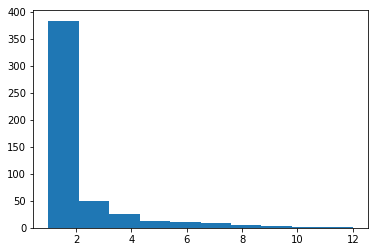

In [31]:
hist([ len( igraph.Graph.Erdos_Renyi( n, 0.1 ).components() ) for n in random.choices( range( 10, 100 ), k=500 ) ])

(array([  0.,   0.,   0.,   0.,   0., 500.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

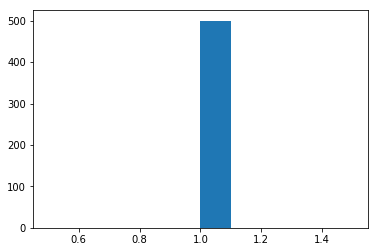

In [33]:
hist([ len( igraph.Graph.Forest_Fire( n, 0.1 ).components() ) for n in random.choices( range( 10, 100 ), k=500 ) ])


In [57]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

Extracting /tmp/ENZYMES/ENZYMES.zip
Processing...
Done!


In [59]:
dataset.root

'/tmp/ENZYMES'

In [130]:
dataset.data.num_nodes

19580

In [193]:
dataset.data

Data(edge_index=[2, 74564], x=[19580, 3], y=[600])